## GAN-based attack

### Train GAN

In [1]:
start_path = "./Gradient_Masking/" ## Format "./  /"

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define generator model
def build_generator(z_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=z_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(28 * 28, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

# Define attack function
def attack_model(victim_model_path, z_dim=100, target_label=3, epochs=1000, batch_size=16):
    generator = build_generator(z_dim)
    log_data = []

    # Load victim model
    victim_model = tf.keras.models.load_model(victim_model_path, safe_mode=False)

    # Loss and optimizer
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(0.0001)
    target_label_tensor = tf.constant([target_label] * batch_size)

    print(f"Victim: {victim_model_path}: ")

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Sample random noise
            z = tf.random.normal([batch_size, z_dim])

            # Generate images
            generated_images = generator(z)

            # Get victim model predictions
            predictions = victim_model(generated_images)

            # Compute loss
            target_loss = loss_fn(target_label_tensor, predictions)
            reg_loss = tf.reduce_mean(tf.square(generated_images - 0.5))
            loss = target_loss + 0.1 * reg_loss

            # Log statistics
            log_data.append({
                "Epoch": epoch + 1,
                "Total Loss": loss.numpy(),
                "Target Loss": target_loss.numpy(),
                "Regularization Loss": reg_loss.numpy()
            })

        # Backpropagation
        gradients = tape.gradient(loss, generator.trainable_variables)
        optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

        if(epoch % 100 == 0):
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")

    # Save the generator and log
    
    generator.save(f"{start_path}generator_inversion_attack_{victim_model_path.split('/')[-1].split('.')[0]}.keras")
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(f"{start_path}attack_log_{victim_model_path.split('/')[-1].split('.')[0]}.csv", index=False)
    print(f"Attack log saved to attack_log_{victim_model_path.split('/')[-1].split('.')[0]}.csv")


In [4]:
# Define dim laten vector
epochs=700
batch_size=16
z_dim=100
target_label=3

In [5]:

# Example usage for different models
attack_model(f"{start_path}victim_simple_cnn_model.keras", 
            z_dim=z_dim, 
            target_label=target_label, 
            epochs=epochs,
            batch_size=batch_size)

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Victim: ./Gradient_Masking/victim_simple_cnn_model.keras: 


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch [0/700], Loss: 3.0919
Epoch [100/700], Loss: 0.0283
Epoch [200/700], Loss: 0.0250
Epoch [300/700], Loss: 0.0153
Epoch [400/700], Loss: 0.0054
Epoch [500/700], Loss: 0.0024
Epoch [600/700], Loss: 0.0017
Attack log saved to attack_log_victim_simple_cnn_model.csv


In [6]:
attack_model(f"{start_path}victim_cnn_model.keras", 
            z_dim=z_dim, 
            target_label=target_label,
            epochs=epochs,
            batch_size=batch_size)

Victim: ./Gradient_Masking/victim_cnn_model.keras: 


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch [0/700], Loss: 2.0408
Epoch [100/700], Loss: 0.0264
Epoch [200/700], Loss: 0.0247
Epoch [300/700], Loss: 0.0234
Epoch [400/700], Loss: 0.0184
Epoch [500/700], Loss: 0.0078
Epoch [600/700], Loss: 0.0038
Attack log saved to attack_log_victim_cnn_model.csv


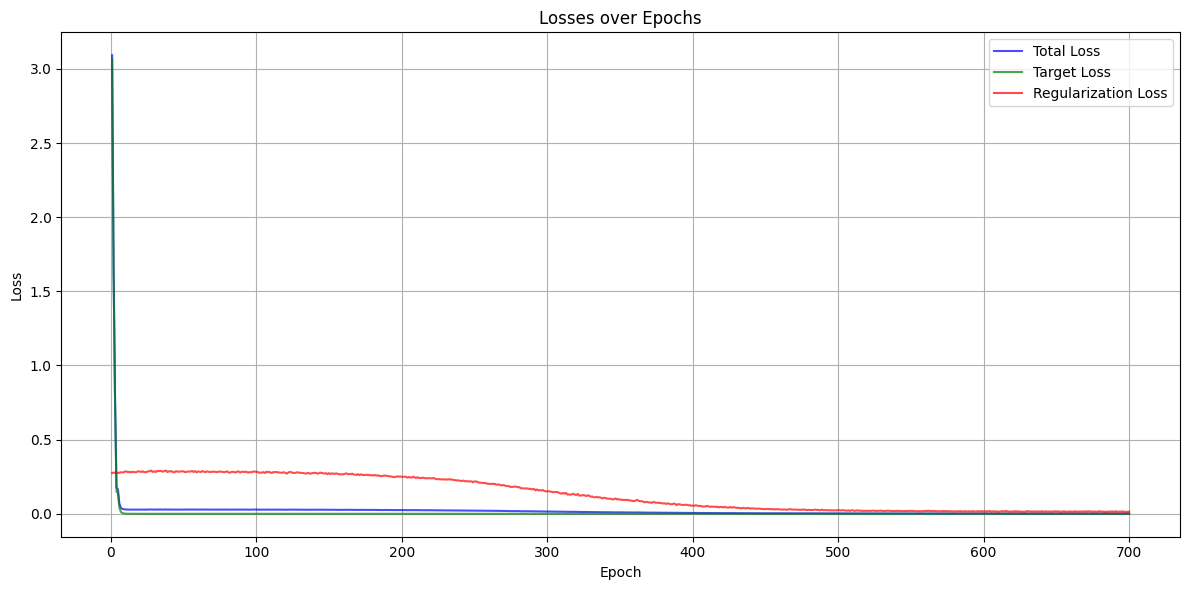

In [7]:
# Convert log data to DataFrame
df_simple_cnm_model_attack_log = pd.read_csv(f"{start_path}attack_log_victim_simple_cnn_model.csv")

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(df_simple_cnm_model_attack_log["Epoch"], df_simple_cnm_model_attack_log["Total Loss"], label="Total Loss", color="blue", alpha=0.7)
plt.plot(df_simple_cnm_model_attack_log["Epoch"], df_simple_cnm_model_attack_log["Target Loss"], label="Target Loss", color="green", alpha=0.7)
plt.plot(df_simple_cnm_model_attack_log["Epoch"], df_simple_cnm_model_attack_log["Regularization Loss"], label="Regularization Loss", color="red", alpha=0.7)
plt.title("Losses over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

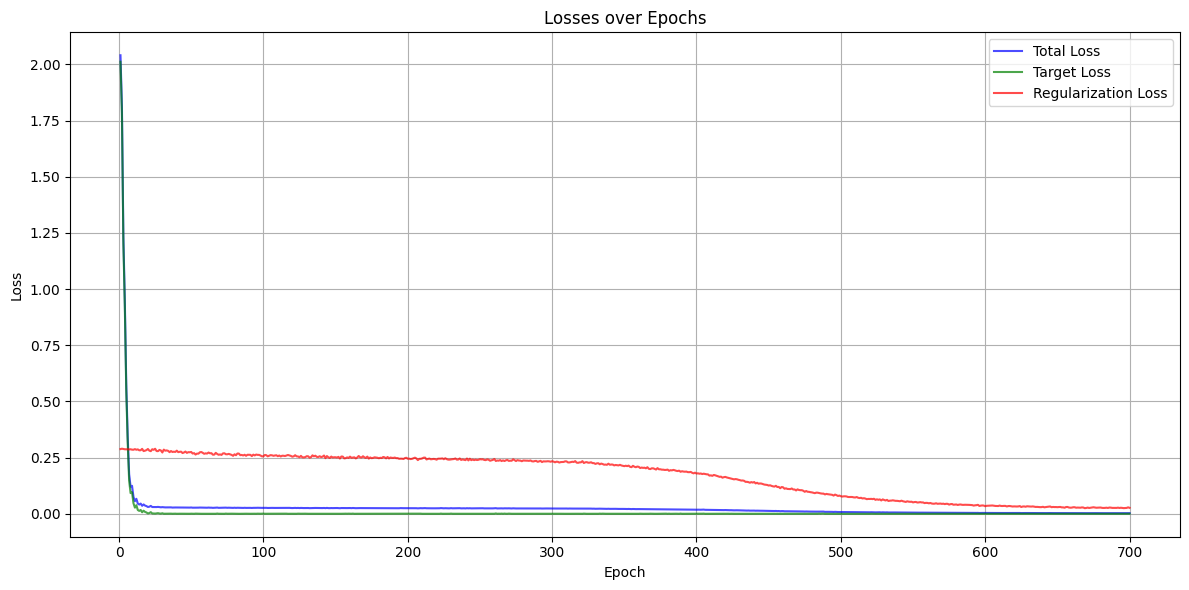

In [8]:
df_cnm_model_attack_log = pd.read_csv(f"{start_path}attack_log_victim_cnn_model.csv")
# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Total Loss"], label="Total Loss", color="blue", alpha=0.7)
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Target Loss"], label="Target Loss", color="green", alpha=0.7)
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Regularization Loss"], label="Regularization Loss", color="red", alpha=0.7)
plt.title("Losses over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

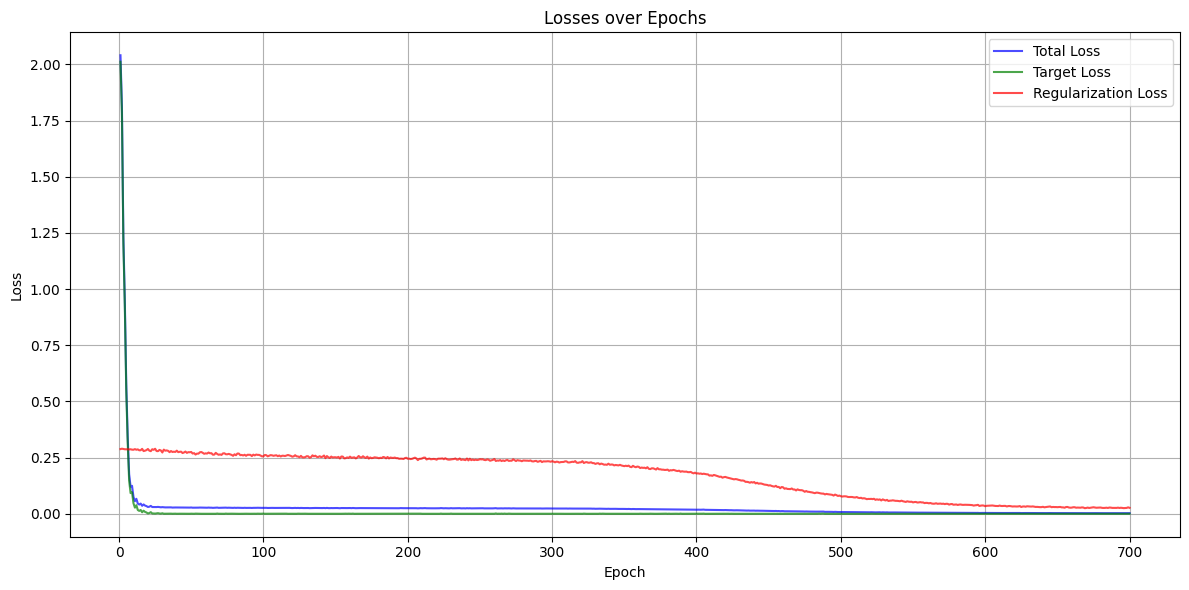

In [9]:
df_cnm_model_attack_log = pd.read_csv(f"{start_path}attack_log_victim_cnn_model.csv")
# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Total Loss"], label="Total Loss", color="blue", alpha=0.7)
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Target Loss"], label="Target Loss", color="green", alpha=0.7)
plt.plot(df_cnm_model_attack_log["Epoch"], df_cnm_model_attack_log["Regularization Loss"], label="Regularization Loss", color="red", alpha=0.7)
plt.title("Losses over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Reconstruct

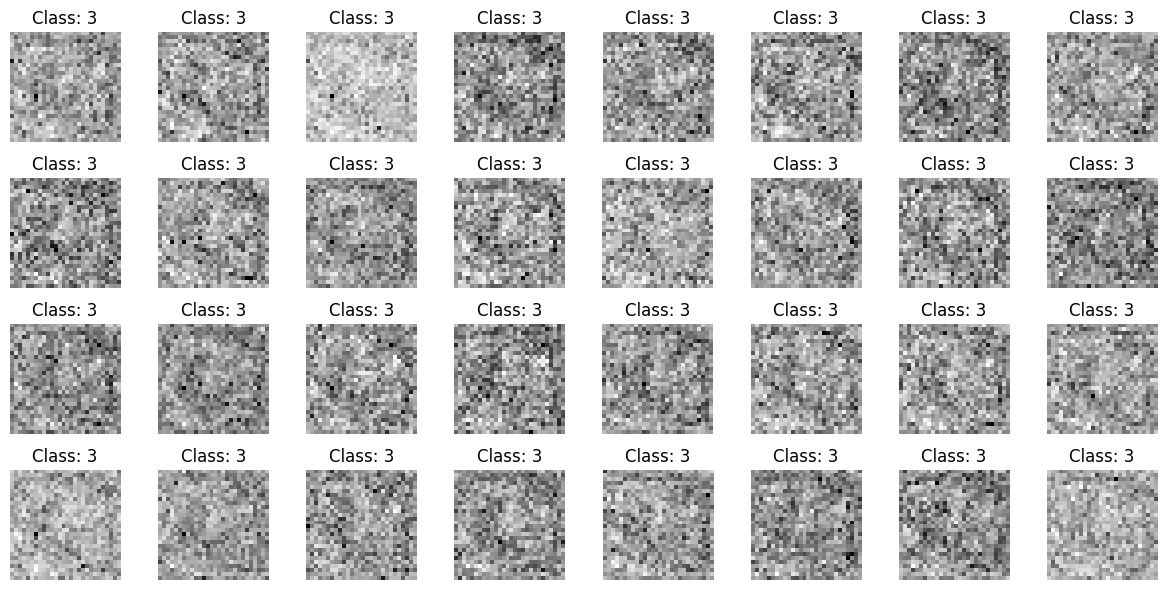

In [10]:
generator_model = tf.keras.models.load_model(f"{start_path}generator_inversion_attack_victim_simple_cnn_model.keras")

# Generate and visualize reconstructed images
z = tf.random.normal([32, z_dim])
generated_images = generator_model(z).numpy()

# Plot generated images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i, :, :, 0], cmap='gray')
    ax.set_title(f"Class: {target_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
simple_cnn_model = tf.keras.models.load_model(f"{start_path}victim_simple_cnn_model.keras")

simple_cnn_model_predictions = simple_cnn_model.predict(generated_images)

for(i, prediction) in enumerate(simple_cnn_model_predictions):
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)  # Get the confidence for the predicted class
    print(f"Image: {i+1}, Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image: 1, Predicted Class: 3, Confidence: 1.0000
Image: 2, Predicted Class: 3, Confidence: 0.9999
Image: 3, Predicted Class: 3, Confidence: 0.9999
Image: 4, Predicted Class: 3, Confidence: 0.9999
Image: 5, Predicted Class: 3, Confidence: 0.9999
Image: 6, Predicted Class: 3, Confidence: 1.0000
Image: 7, Predicted Class: 3, Confidence: 0.9999
Image: 8, Predicted Class: 3, Confidence: 1.0000
Image: 9, Predicted Class: 3, Confidence: 0.9999
Image: 10, Predicted Class: 3, Confidence: 1.0000
Image: 11, Predicted Class: 3, Confidence: 0.9999
Image: 12, Predicted Class: 3, Confidence: 1.0000
Image: 13, Predicted Class: 3, Confidence: 0.9999
Image: 14, Predicted Class: 3, Confidence: 0.9999
Image: 15, Predicted Class: 3, Confidence: 0.9999
Image: 16, Predicted Class: 3, Confidence: 1.0000
Image: 17, Predicted Class: 3, Confidence: 0.9999
Image: 18, Predicted Class: 3, Confidence: 0.9999
Image: 19, Predicted Class: 3, Confidence: 0.9999
Image: 20, Predicted 

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


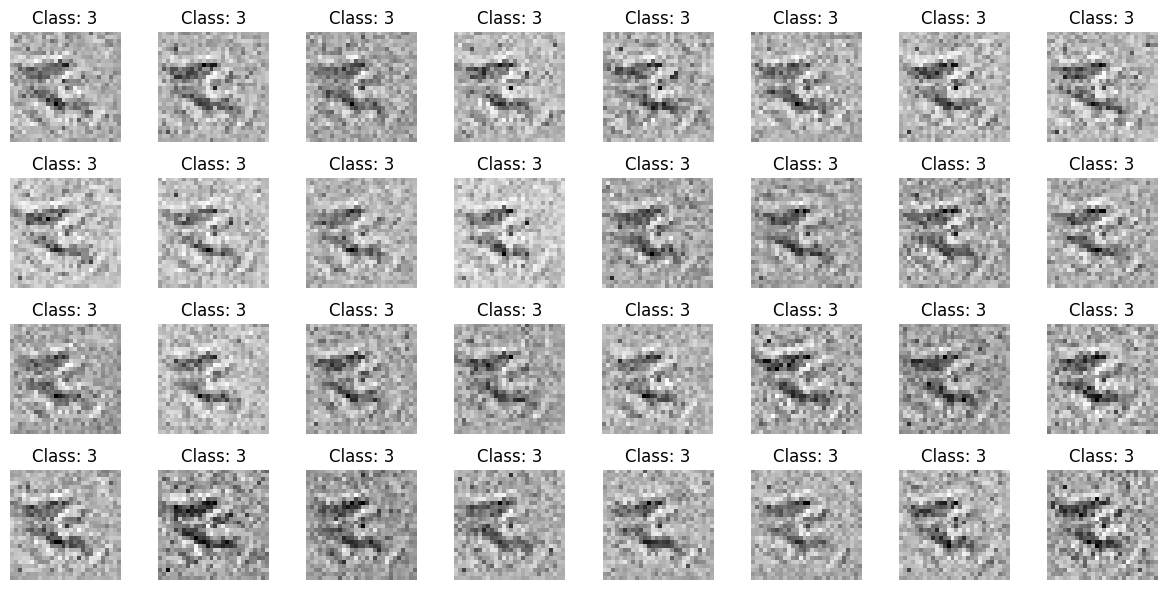

In [12]:
generator_model = tf.keras.models.load_model(f"{start_path}generator_inversion_attack_victim_cnn_model.keras")

# Generate and visualize reconstructed images
z = tf.random.normal([32, z_dim])
generated_images = generator_model(z).numpy()

# Plot generated images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i, :, :, 0], cmap='gray')
    ax.set_title(f"Class: {target_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
cnn_model = tf.keras.models.load_model(f"{start_path}victim_cnn_model.keras")

cnn_model_predictions = cnn_model.predict(generated_images)

for(i, prediction) in enumerate(cnn_model_predictions):
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)  # Get the confidence for the predicted class
    print(f"Image: {i+1}, Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image: 1, Predicted Class: 3, Confidence: 0.9999
Image: 2, Predicted Class: 3, Confidence: 1.0000
Image: 3, Predicted Class: 3, Confidence: 0.9997
Image: 4, Predicted Class: 3, Confidence: 1.0000
Image: 5, Predicted Class: 3, Confidence: 0.9999
Image: 6, Predicted Class: 3, Confidence: 0.9999
Image: 7, Predicted Class: 3, Confidence: 1.0000
Image: 8, Predicted Class: 3, Confidence: 0.9999
Image: 9, Predicted Class: 3, Confidence: 0.9999
Image: 10, Predicted Class: 3, Confidence: 0.9999
Image: 11, Predicted Class: 3, Confidence: 1.0000
Image: 12, Predicted Class: 3, Confidence: 1.0000
Image: 13, Predicted Class: 3, Confidence: 0.9999
Image: 14, Predicted Class: 3, Confidence: 1.0000
Image: 15, Predicted Class: 3, Confidence: 0.9998
Image: 16, Predicted Class: 3, Confidence: 0.9999
Image: 17, Predicted Class: 3, Confidence: 0.9993
Image: 18, Predicted Class: 3, Confidence: 0.9999
Image: 19, Predicted Class: 3, Confidence: 0.9999
Image: 20, Predicted 

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
